In [89]:
from __future__ import annotations
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [90]:
MAIN_DIR = '/Users/alex/Desktop/CS/Internships/DBF/Alex_DBF/python_tools/data/year2/01-28-2025'
OUTPUT_DIR = MAIN_DIR + '/output'

In [91]:
MIN_THROTTLE = 1000
MAX_THROTTLE = 2011

In [92]:
blackbox_dfs: dict[str, pd.DataFrame] = {}

for file in os.listdir(MAIN_DIR):
    if file.endswith('.csv'):
        blackbox_dfs[file.removesuffix('.csv')] = pd.read_csv(MAIN_DIR + '/' + file, comment='#')

blackbox_dfs.keys()

dict_keys(['AT5330_220KV_16X12_RUN1', 'AT5330_220KV_3X15X14R_RUN1', 'AT5330_220KV_18X10CFRP_RUN1', 'AT5520_220KV_18X10CFRP_RUN1', 'AT5520_220KV_16X12_RUN1', 'AT5520_220KV_3X15X14R_RUN1'])

In [98]:
torque_dfs: dict[str, pd.DataFrame] = {}

for file in os.listdir(MAIN_DIR):
    if file.endswith('.txt'):
        try:
            torque_dfs[file.removesuffix('.txt')] = pd.read_csv(MAIN_DIR + '/' + file, header=None)
            torque_dfs[file.removesuffix('.txt')].columns = ['loopIteration', 'thrust', 'torque', 'ignore_1', 'ignore2']
        except:
            print(f'Error reading {file}')
torque_dfs.keys()

dict_keys(['AT5520_220KV_18X10CFRP_RUN1', 'AT5520_220KV_3X15X14R_RUN1', 'AT5520_220KV_16X12_RUN1', 'AT5330_220KV_16X12_RUN1', 'AT5330_220KV_3X15X14R_RUN1', 'AT5330_220KV_18X10CFRP_RUN1'])

In [99]:
# find non common df names
torque_only_dfs = set(torque_dfs.keys()).difference(set(blackbox_dfs.keys()))
print('Torque but not blackbox:', torque_only_dfs)

blackbox_only_dfs = set(blackbox_dfs.keys()).difference(set(torque_dfs.keys()))
print('Blackbox but not torque:', blackbox_only_dfs)

Torque but not blackbox: set()
Blackbox but not torque: set()


In [100]:
# find common df names
common_dfs = set(blackbox_dfs.keys()).intersection(set(torque_dfs.keys()))
print(common_dfs)

{'AT5520_220KV_16X12_RUN1', 'AT5520_220KV_18X10CFRP_RUN1', 'AT5330_220KV_16X12_RUN1', 'AT5520_220KV_3X15X14R_RUN1', 'AT5330_220KV_18X10CFRP_RUN1', 'AT5330_220KV_3X15X14R_RUN1'}


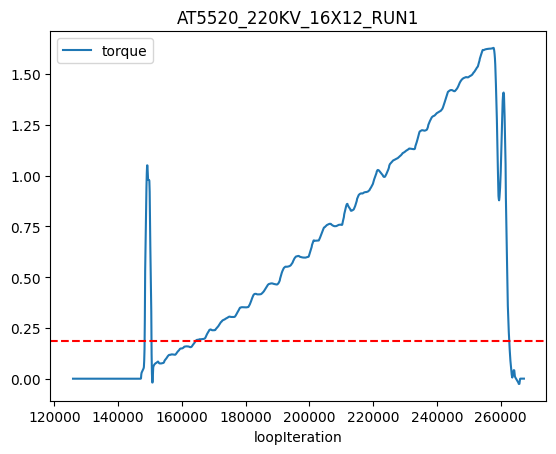

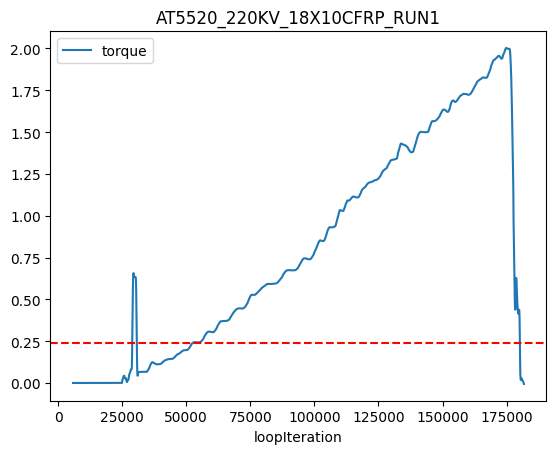

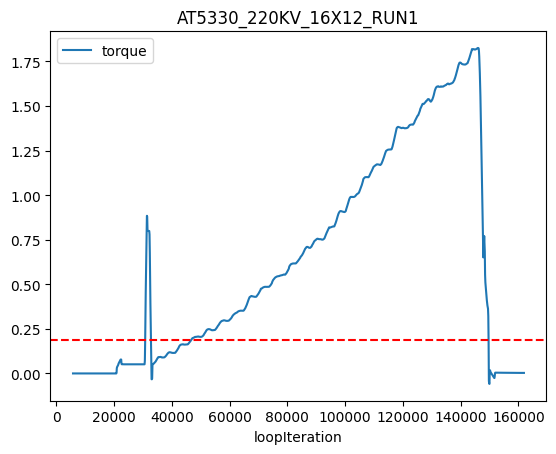

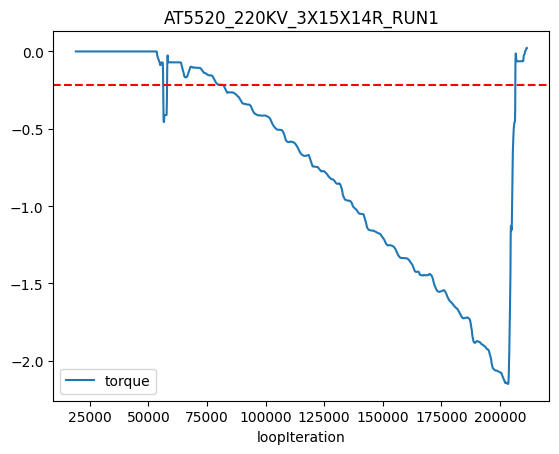

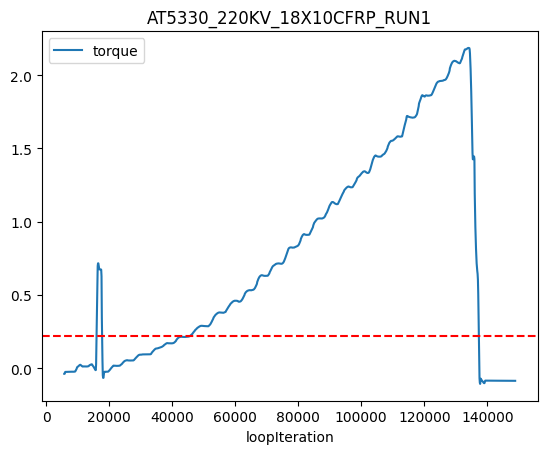

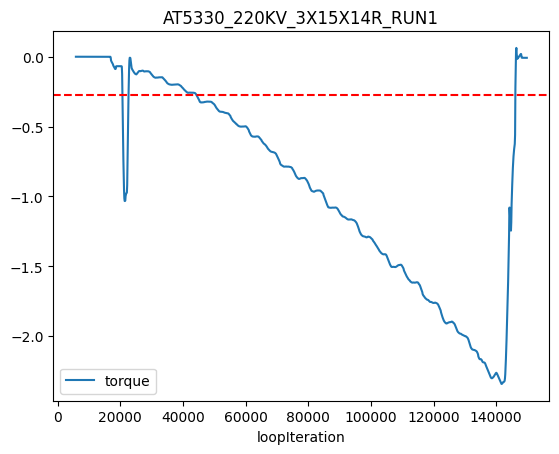

In [101]:
for key in common_dfs:
    ax = torque_dfs[key].plot(x='loopIteration', y='torque', title=key)
    ax.axhline(torque_dfs[key]['torque'].mean() * 0.3, color='r', linestyle='--')

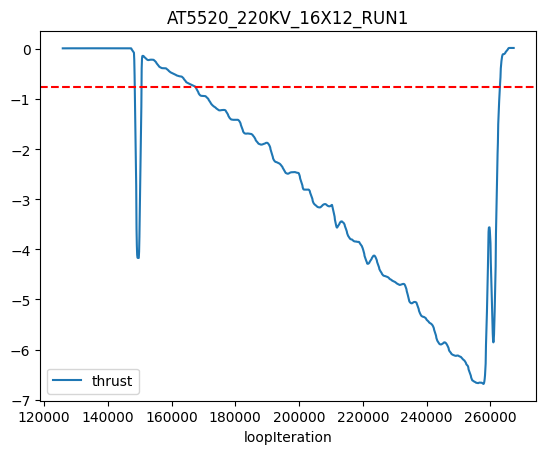

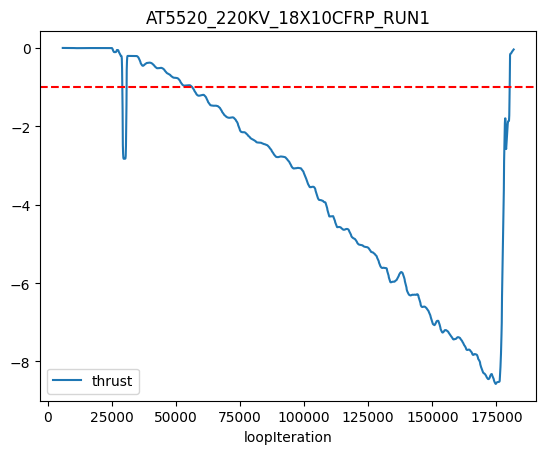

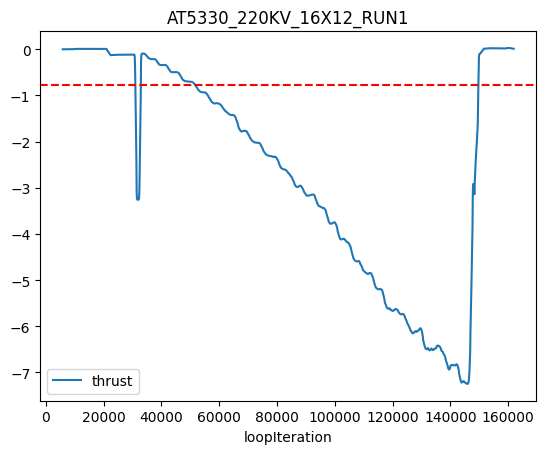

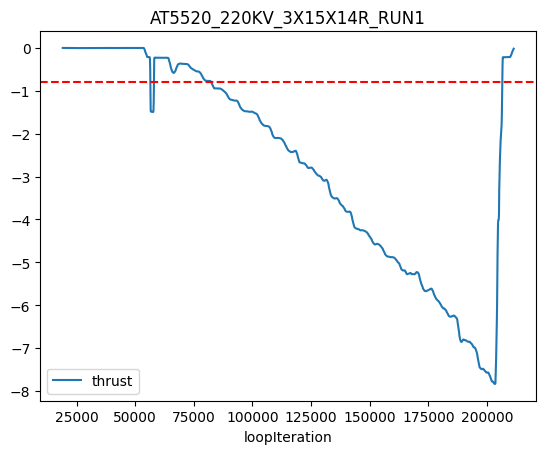

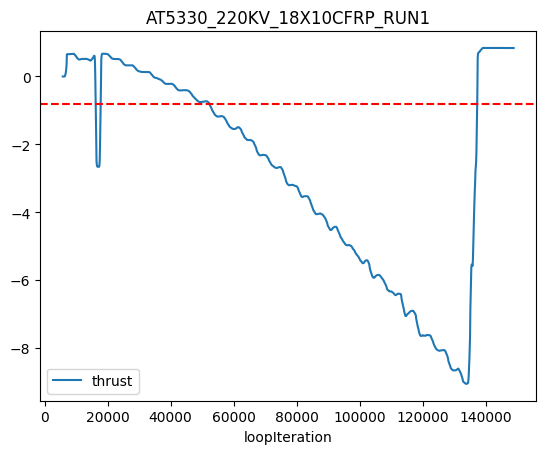

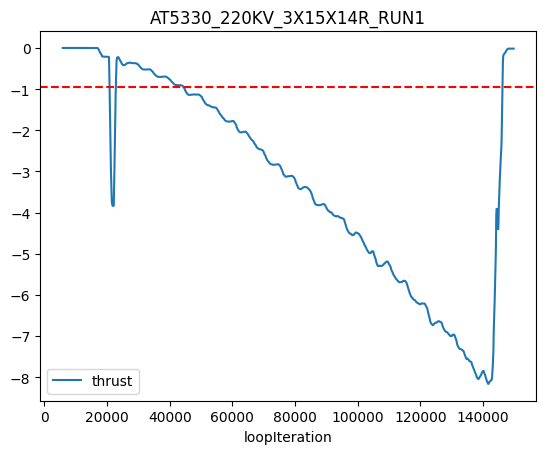

In [102]:
for key in common_dfs:
    ax = torque_dfs[key].plot(x='loopIteration', y='thrust', title=key)
    ax.axhline(torque_dfs[key]['thrust'].mean() * 0.3, color='r', linestyle='--')

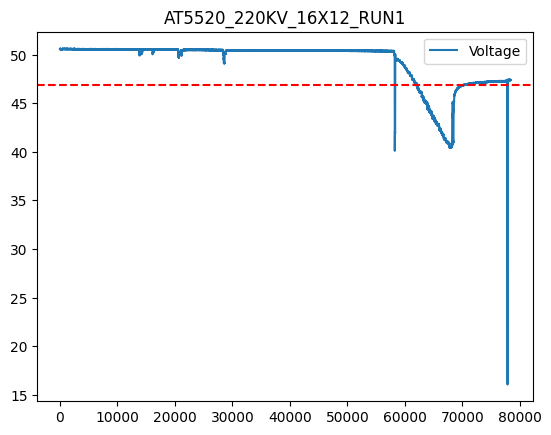

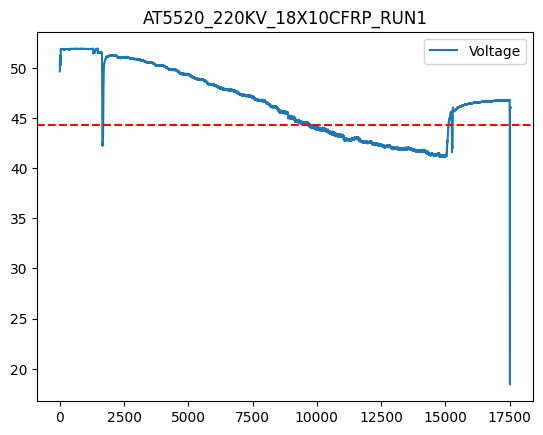

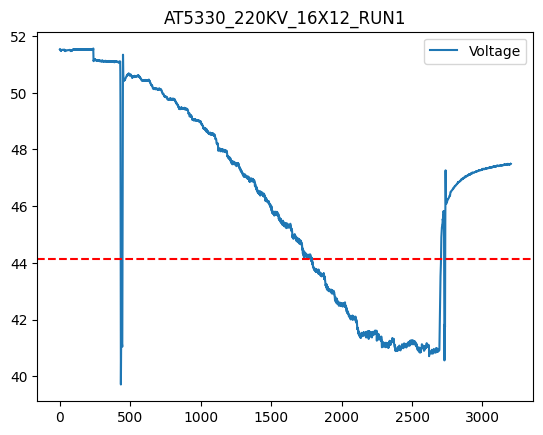

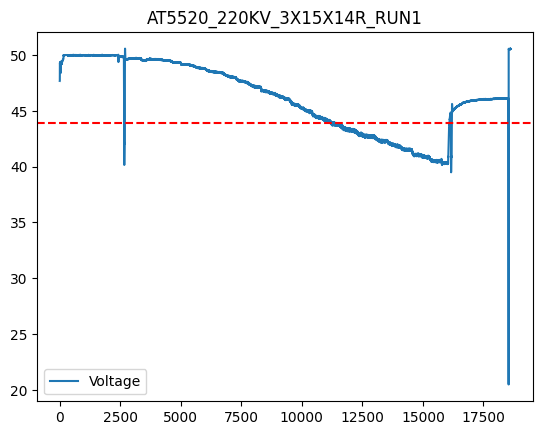

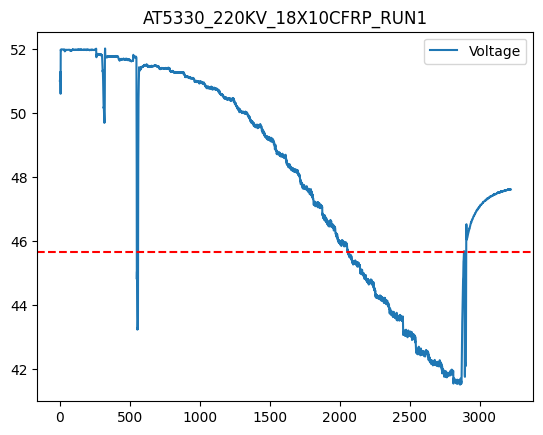

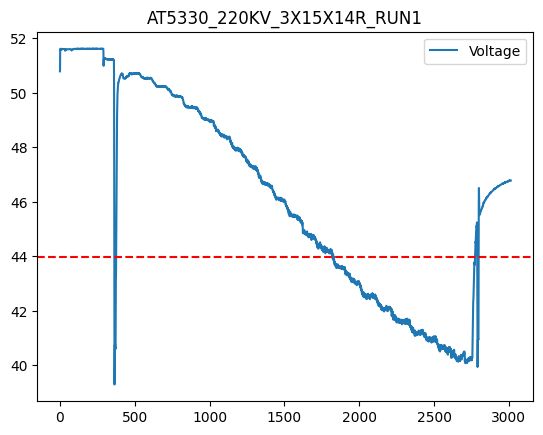

In [103]:
for key in common_dfs:
    ax = blackbox_dfs[key].plot(y='Voltage', title=key)
    ax.axhline(blackbox_dfs[key]['Voltage'].mean() * 0.95, color='r', linestyle='--')

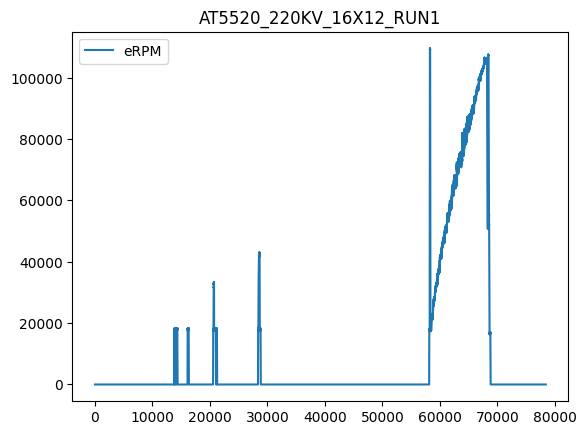

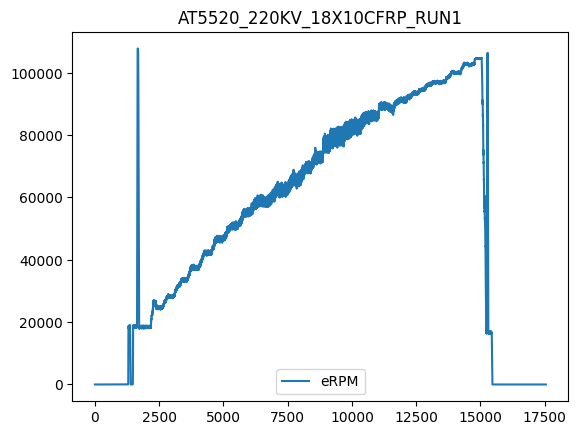

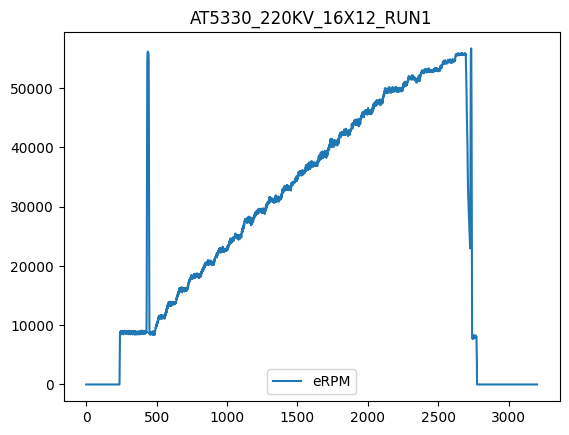

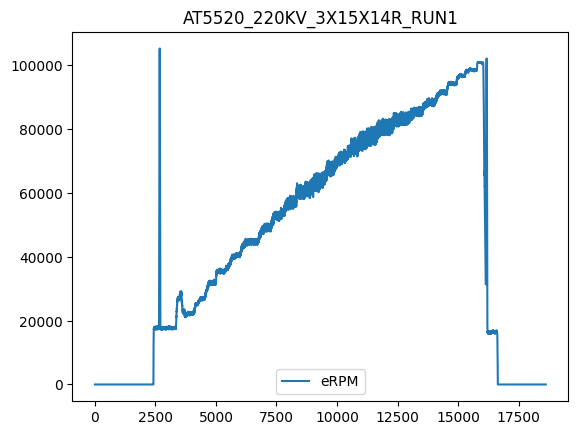

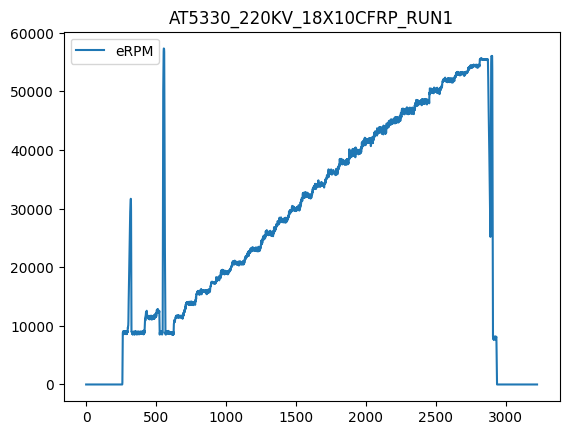

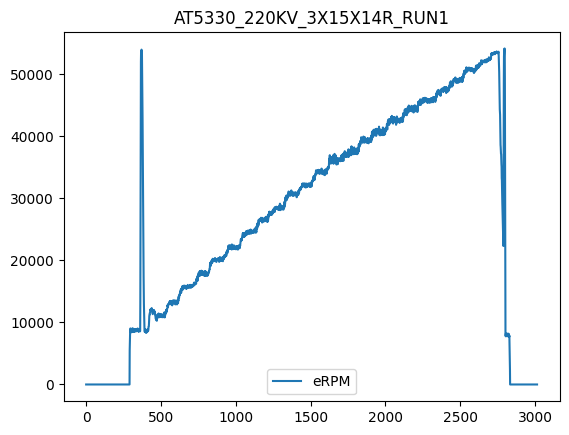

In [104]:
for key in common_dfs:
    ax = blackbox_dfs[key].plot(y='eRPM', title=key)

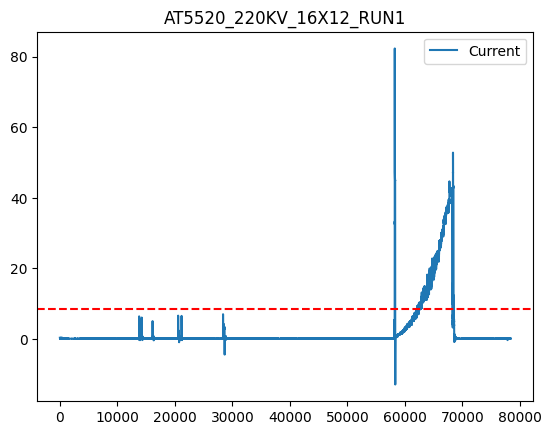

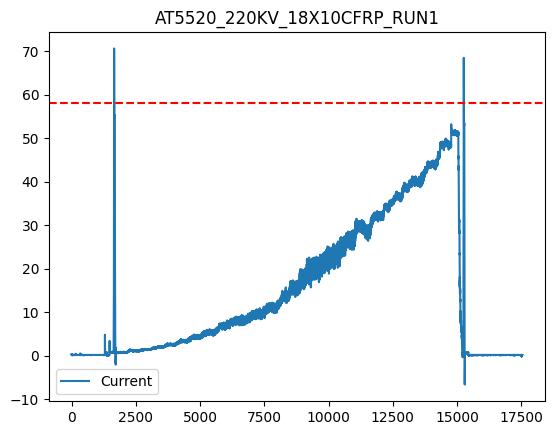

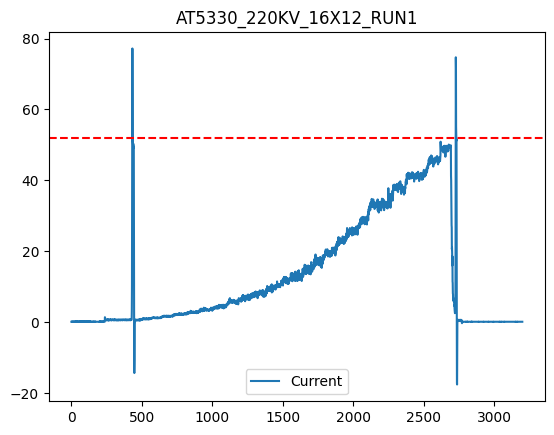

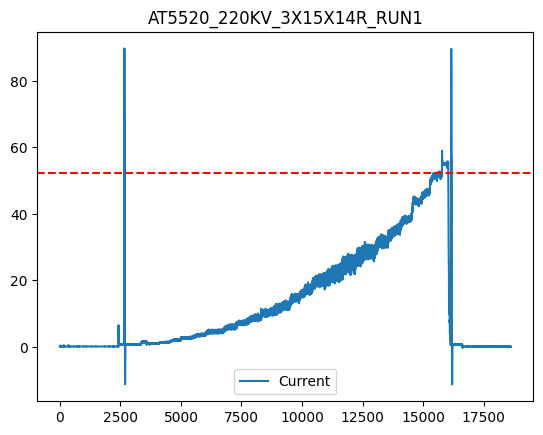

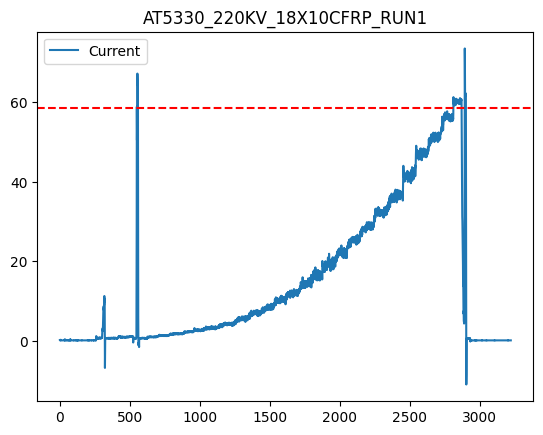

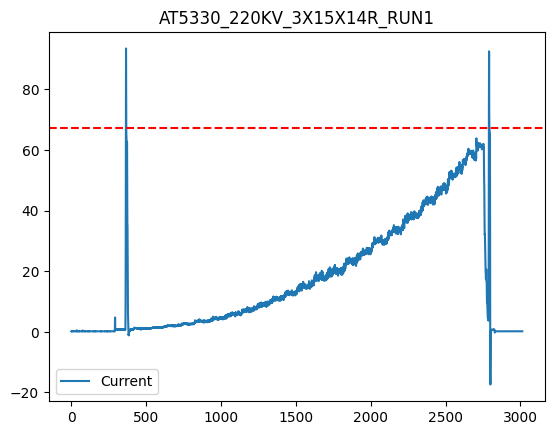

In [105]:
for key in common_dfs:
    ax = blackbox_dfs[key].plot(y='Current', title=key)
    ax.axhline(blackbox_dfs[key]['Current'].mean() * 4, color='r', linestyle='--')

AT5520_220KV_16X12_RUN1
AT5520_220KV_3X15X14R_RUN1
AT5520_220KV_18X10CFRP_RUN1


/var/folders/gz/pp4ldsnj0tjbngm2gygkp8qc0000gn/T/ipykernel_95247/1885543073.py:41: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_bucketed_by_current = df.groupby(pd.cut(df['Current'], bins=20)).mean()
/var/folders/gz/pp4ldsnj0tjbngm2gygkp8qc0000gn/T/ipykernel_95247/1885543073.py:45: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_bucketed_by_voltage = df.groupby(pd.cut(df['Voltage'], bins=20)).mean()
/var/folders/gz/pp4ldsnj0tjbngm2gygkp8qc0000gn/T/ipykernel_95247/1885543073.py:49: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only 

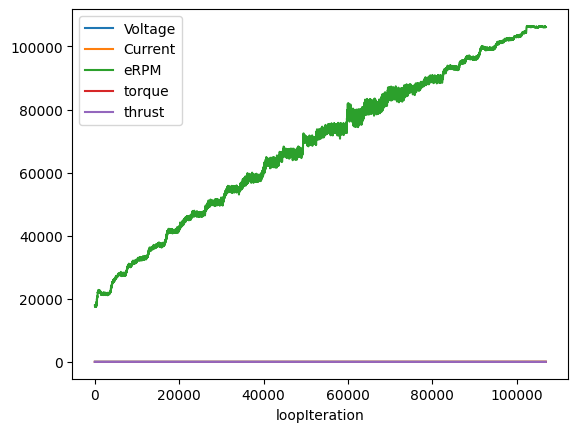

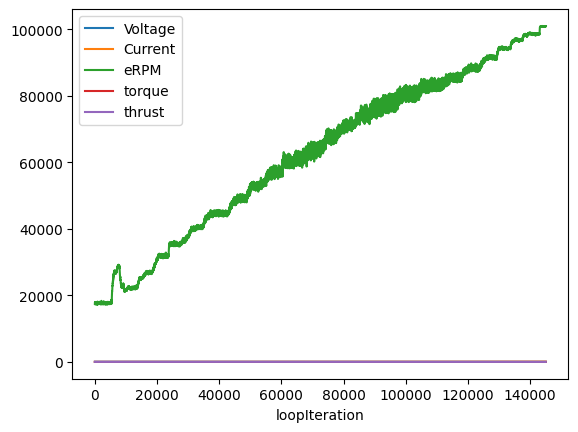

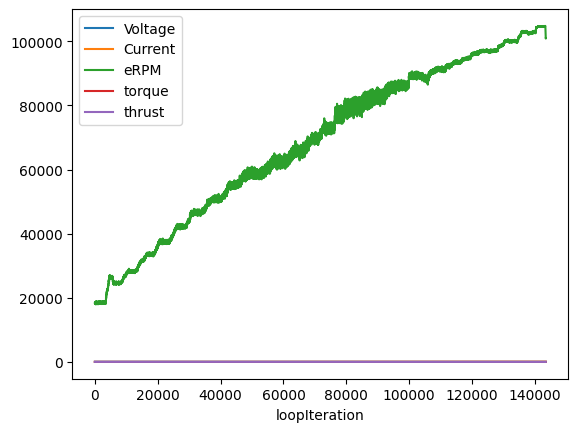

In [ ]:
BLACKBOX_COLS = ['Voltage', 'Current', 'eRPM']
TORQUE_COLS = ['torque', 'thrust']
METADATA = ['motor', 'kv', 'prop', 'run']

for name in list(common_dfs):
    print(name)

    metadata = dict(zip(METADATA, name.split("_")))

    df = blackbox_dfs[name][BLACKBOX_COLS].copy()
    first_peak = df['Current'].idxmax() #df['Current'].gt(df['Current'].mean() * 4).idxmax()
    last_peak = df['Current'].iloc[int(first_peak)+2000:].idxmax()
    df = df.iloc[first_peak+200:last_peak-200]
    df.reset_index(drop=True, inplace=True)

    df_torque = torque_dfs[name][['loopIteration'] + TORQUE_COLS].copy()
    df_torque['loopIteration'] = df_torque['loopIteration'].astype(np.int64)
    peak_thrust_it = df_torque['loopIteration'][df_torque['thrust'].lt(df_torque['thrust'].mean() * 0.3).idxmax()]
    df_torque = df_torque[df_torque['loopIteration'].ge(peak_thrust_it)]
    min_thrust_it = df_torque['loopIteration'][df_torque['thrust'].idxmin()]
    df_torque = df_torque[df_torque['loopIteration'].le(min_thrust_it)]
    max_thrust_it = df_torque['loopIteration'][df_torque['thrust'].idxmax()]
    df_torque = df_torque[df_torque['loopIteration'].ge(max_thrust_it)]
    df_torque['loopIteration'] -= df_torque['loopIteration'].min()
    df_torque_len = df_torque['loopIteration'].max() - df_torque['loopIteration'].min()

    len_ratio = df_torque_len / len(df)

    df['loopIteration'] = np.int64(df.index * len_ratio)
    
    df = pd.merge_asof(df, df_torque, left_on='loopIteration', right_on='loopIteration', direction='nearest')

    for col in METADATA:
        df[col] = metadata[col]

    df = df[['loopIteration'] + BLACKBOX_COLS + TORQUE_COLS + METADATA]
    df.to_csv(OUTPUT_DIR + "/" + name + ".csv", index=False)
    df.plot(x='loopIteration')
    plt.savefig(OUTPUT_DIR + "/" + name + ".png")

    df_bucketed_by_current = df.groupby(pd.cut(df['Current'], bins=20)).mean()
    df_bucketed_by_current.drop(columns=['loopIteration'], inplace=True)
    df_bucketed_by_current.to_csv(OUTPUT_DIR + "/" + name + "_bucketed_by_current.csv")
    
    df_bucketed_by_voltage = df.groupby(pd.cut(df['Voltage'], bins=20)).mean()
    df_bucketed_by_voltage.drop(columns=['loopIteration'], inplace=True)
    df_bucketed_by_voltage.to_csv(OUTPUT_DIR + "/" + name + "_bucketed_by_voltage.csv")

    df_bucketed_by_torque = df.groupby(pd.cut(df['torque'], bins=20)).mean()
    df_bucketed_by_torque.drop(columns=['loopIteration'], inplace=True)
    df_bucketed_by_torque.to_csv(OUTPUT_DIR + "/" + name + "_bucketed_by_torque.csv")

    df_bucketed_by_thrust = df.groupby(pd.cut(df['thrust'], bins=20)).mean()
    df_bucketed_by_thrust.drop(columns=['loopIteration'], inplace=True)
    df_bucketed_by_thrust.to_csv(OUTPUT_DIR + "/" + name + "_bucketed_by_thrust.csv")

    df_bucketed_by_time = df.groupby(pd.cut(df['loopIteration'], bins=20)).mean()
    df_bucketed_by_time.drop(columns=['loopIteration'], inplace=True)
    df_bucketed_by_time.to_csv(OUTPUT_DIR + "/" + name + "_bucketed_by_time.csv")

58238
[384, 576, 864, 1056, 1248, 1440, 1632, 1920, 2112, 2400, 2592, 2976, 3360, 3744, 4032, 4512, 4800, 4992, 5472, 5664, 5952, 6336, 6720, 7008, 7200, 7584, 7968, 8352, 8736, 8928, 9312]
1658
[524, 917, 1310, 1572, 1834, 2358, 2751, 3013, 3406, 3799, 4061, 4454, 5109, 5371, 5895, 6419, 6812, 7205, 7467, 7991, 8515, 8777, 9301, 9694, 10087, 10480, 10873, 11397, 12052, 12445, 12969]
433
[102, 204, 289, 323, 408, 510, 595, 680, 782, 850, 884, 1020, 1105, 1190, 1275, 1343, 1428, 1496, 1666, 1768]
2665
[650, 1300, 1560, 1950, 2340, 2730, 2990, 3380, 4030, 4290, 4680, 5070, 5590, 6110, 6370, 6760, 7150, 7410, 7800, 8450, 8970, 9490, 9880, 10400, 10920, 11440, 12220, 12610]
2894
Error with AT5330_220KV_18X10CFRP_RUN1
[57, 133, 209, 342, 380, 456, 570, 665, 703, 779, 855, 950, 1026, 1121, 1216, 1292, 1387, 1463, 1501, 1577, 1767, 1881, 1976]
365
[95, 190, 266, 380, 475, 589, 665, 703, 798, 893, 988, 1083, 1273, 1368, 1482, 1596, 1786, 1881]


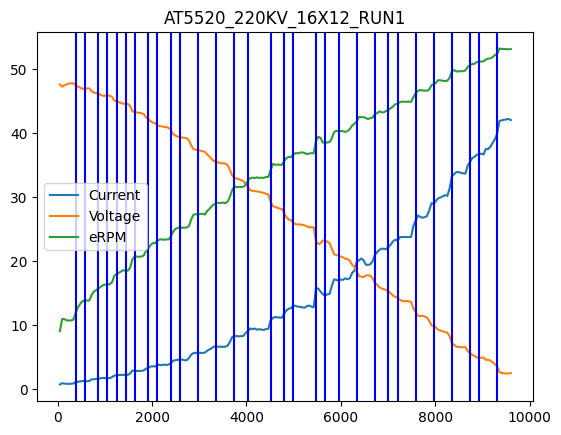

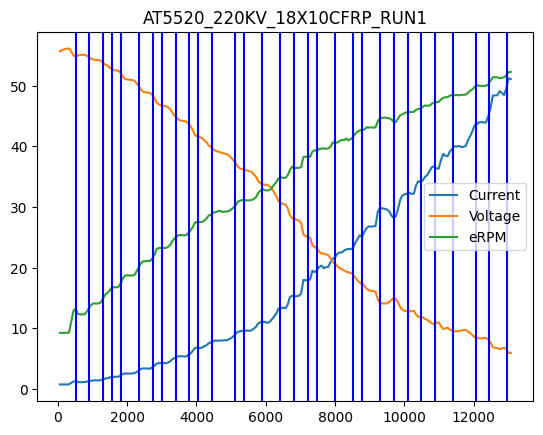

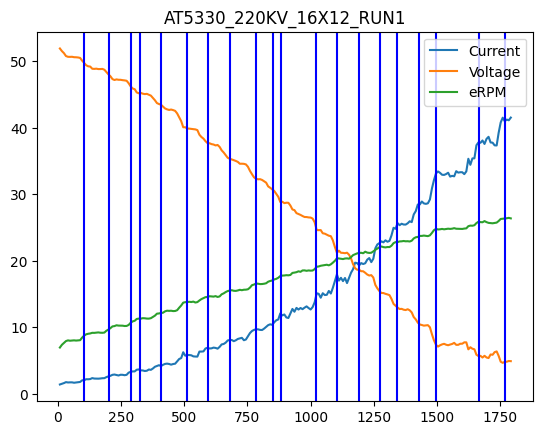

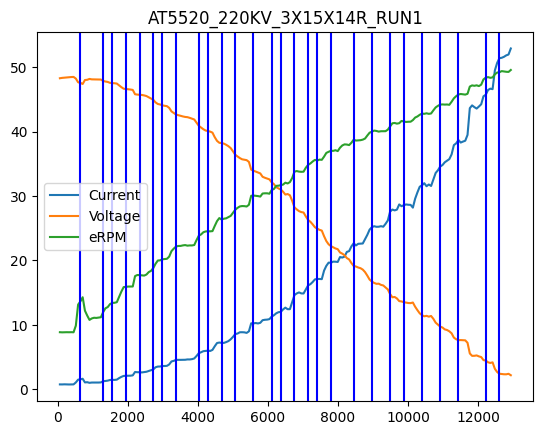

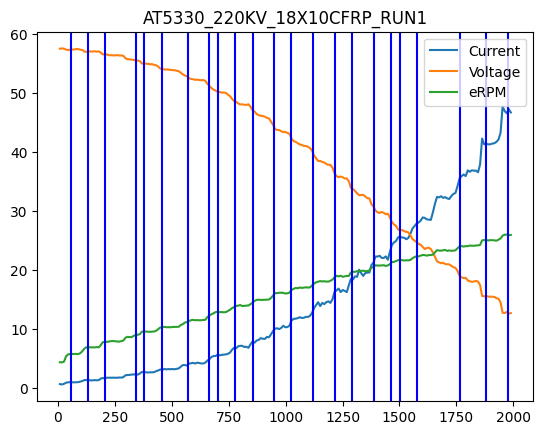

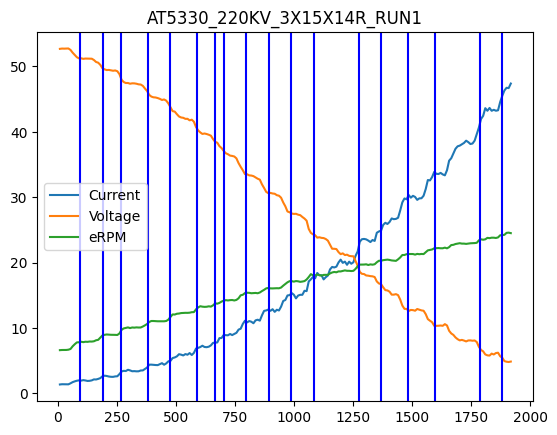

In [196]:
BLACKBOX_COLS = ['Current', 'Voltage', 'eRPM']
SCALES = [lambda x: x, lambda x: 5 * (x - 40), lambda x: x/2000]
for name in common_dfs:
    df = blackbox_dfs[name].copy()

    # Find relevant portion based on start and stop signals
    first_peak = df['Current'].idxmax()
    print(first_peak)
    try:
        last_peak = df['Current'].iloc[int(first_peak)+2000:].idxmax()
    except:
        print('Error with', name)
        first_peak = 400
        last_peak = df['Current'].iloc[400:].idxmax()
    df = df.iloc[int(first_peak)+200:int(last_peak)-300]
    df = df[df['Motor Started (24)'] == 1]
    df.reset_index(drop=True, inplace=True)

    # smoothen out with moving average
    def smoothen(downsample_factor):
        return df.rolling(window=int(len(df)/downsample_factor)).mean()[::int(len(df)/downsample_factor)]
    downsampled = smoothen(100)

    # find steps
    col = 'eRPM'
    bins = downsampled[col].index[(downsampled[col] - downsampled[col].shift(1)).apply(lambda x: np.sqrt(np.abs(x)) > 20)].tolist()
    # bin_cutoffs = df.index[bins].tolist()
    bins = bins[1::2]
    print(bins)

    # Plot info
    display_df = smoothen(200)
    for c, s in zip(BLACKBOX_COLS, SCALES):
        display_df[c] = display_df[c].apply(s)
    display_df[BLACKBOX_COLS].plot()
    plt.title(name)
    for x in bins:
        plt.axvline(x = x, color = 'b', label = 'axvline - full height')
    plt.savefig(OUTPUT_DIR + "/" + name + ".png")

    # Average within each step
    df['group'] = pd.qcut(df.index, q=[0] + [val / len(df) for val in bins] + [1], labels=list(map(str, bins)) + ["max"])
    df = df.groupby('group').mean()
    df.reset_index(inplace=True)
    df.drop(columns=['group'], inplace=True)
    df[BLACKBOX_COLS].to_csv(OUTPUT_DIR + "/" + name + ".csv", index=False)